In [1]:
import pickle
import os

from scipy.signal import medfilt
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools 
import pandas as pd

## Learning Curve Plots

In [9]:
def plot_learning_average(env_name, ax, experiment, window_size, var = True, OnePlayer = False):
    if OnePlayer:
        base_dir = os.getcwd() + '/models_OnePlayer/' + env_name
    else:
        base_dir = os.getcwd() + '/models/' + env_name
    results = {}
        
    for exp in experiment:
        results[exp] = {}
        for seed in range(5):
            try:
                if(OnePlayer):
                    with open(base_dir + '/' + exp +'/nr_mdp_0_1/' + str(seed) + '/results', 'rb') as f:
                        results[exp][seed] = pickle.load(f)
                else:
                    with open(base_dir + '/' + exp +'/nr_mdp_0.1_1/' + str(seed) + '/results', 'rb') as f:
                        results[exp][seed] = pickle.load(f)                
            except IOError:
                pass
            
    avg, std = plot_learning_curves(results, ax, env_name, window_size, var, OnePlayer, best = False)
    return avg, std

def plot_learning_best(env_name, seed, ax, experiment, window_size, var = True, OnePlayer = False):
    if OnePlayer:
        base_dir = os.getcwd() + '/models_OnePlayer/' + env_name
    else:
        base_dir = os.getcwd() + '/models/' + env_name
    results = {}
        
    for i, exp in enumerate(experiment):
        results[exp] = {}
        try:
            if(OnePlayer):
                with open(base_dir + '/' + exp +'/nr_mdp_0_1/' + str(seed[i]) + '/results', 'rb') as f:
                    results[exp] = pickle.load(f)
            else:
                with open(base_dir + '/' + exp +'/nr_mdp_0.1_1/' + str(seed[i]) + '/results', 'rb') as f:
                    results[exp] = pickle.load(f)                
        except IOError:
            pass
            
    avg, std = plot_learning_curves(results, ax, env_name, window_size, var, OnePlayer, best = True)
    return avg, std
   
def plot_learning_curves(results, ax, env_name, window_size, var, OnePlayer, best):    
    colors = ['#396ab1', '#3e9651', '#cc2529', '#396ab1', '#da7c30', '#94823d', '#535154', '#006400', '#00FF00', '#800000', '#F08080', '#FFFF00', '#000000', '#C0C0C0']

    idx = 0
    final_avg = []
    final_std = []
    for exp in results:
        if(best):
            merged = list(itertools.chain(*(results[exp]['eval_rewards'])))
        else:
            reward = []    
            for seed in results[exp]:
                reward.append(list(itertools.chain(*(results[exp][seed]['eval_rewards']))))
            merged = list(itertools.chain.from_iterable(reward))
        out = np.array(merged) 
        out = out.reshape(-1,2)
        df = pd.DataFrame({'Column1':out[:,0],'Column2':out[:,1]})
        length = int(df.Column1.values[-1]/window_size)
        x = np.zeros(length)
        y_avg = np.zeros(length)
        y_std = np.zeros(length)
        for i in range(1, length):
            data = (df[(df.Column1 <= window_size * i) & (df.Column1 > window_size * (i-1))]).Column2.values
            x[i] = window_size * i
            y_avg[i] = np.mean(data)
            y_std[i] = np.std(data)
        avg = y_avg[-10:]
        final_avg.append(np.mean(avg))
        final_std.append(np.std(avg))
        if 'RMSprop' in exp:
            l = 'GAD(RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        else:
            l = 'MixedNE-LD(RMSProp)'       
        ax.plot(x, y_avg, color = colors[idx], label = l)
        if (var):
            ax.fill_between(x, (y_avg)-(y_std), (y_avg)+(y_std), facecolor=colors[idx], alpha=0.4, interpolate=True)
        idx += 1  
    
    ax.set_title(env_name)    
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Reward')
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))    
    return final_avg, final_std

In [10]:
def plot_learning_all(experiment, title, comparison, OnePlayer, best, seed=None):
    cols = 2
    rows = 4
    envs = ['Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Ant-v2', 'Swimmer-v2', 'Reacher-v2', 'Humanoid-v2', 'InvertedPendulum-v2']
    fill = [True, False]
    for f in fill:
        fig, axs = plt.subplots(rows, cols, figsize=(20*cols/3, 9*rows/2))
        for i, env in enumerate(envs):
            ax = axs.flatten()[i]
            if(comparison):
                exp = experiment[i]
            else:
                exp = experiment
            if(best):
                plot_learning_best(env, seed[i], ax, exp, window_size = 3000, var = f, OnePlayer = OnePlayer)
            else:
                plot_learning_average(env, ax, exp, window_size = 3000, var = f, OnePlayer = OnePlayer)
            if(comparison):
                ax.legend()
            else:
                if i == 0:
                    ax.legend()
        plt.tight_layout()
        
        if(OnePlayer):
            folder = 'OnePlayer'
        else:
            folder = 'TwoPlayer'
            
        if(f):
            if(best):
                plt.savefig('plots/'+ folder + '/Learning_curve/' + title +'_best_fill.pdf')
            else:
                plt.savefig('plots/'+ folder + '/Learning_curve/' + title +'_average_fill.pdf')                    
        else:
            if(best):
                plt.savefig('plots/'+ folder + '/Learning_curve/' + title +'_best.pdf')
            else:
                plt.savefig('plots/'+ folder + '/Learning_curve/' + title +'_average.pdf')


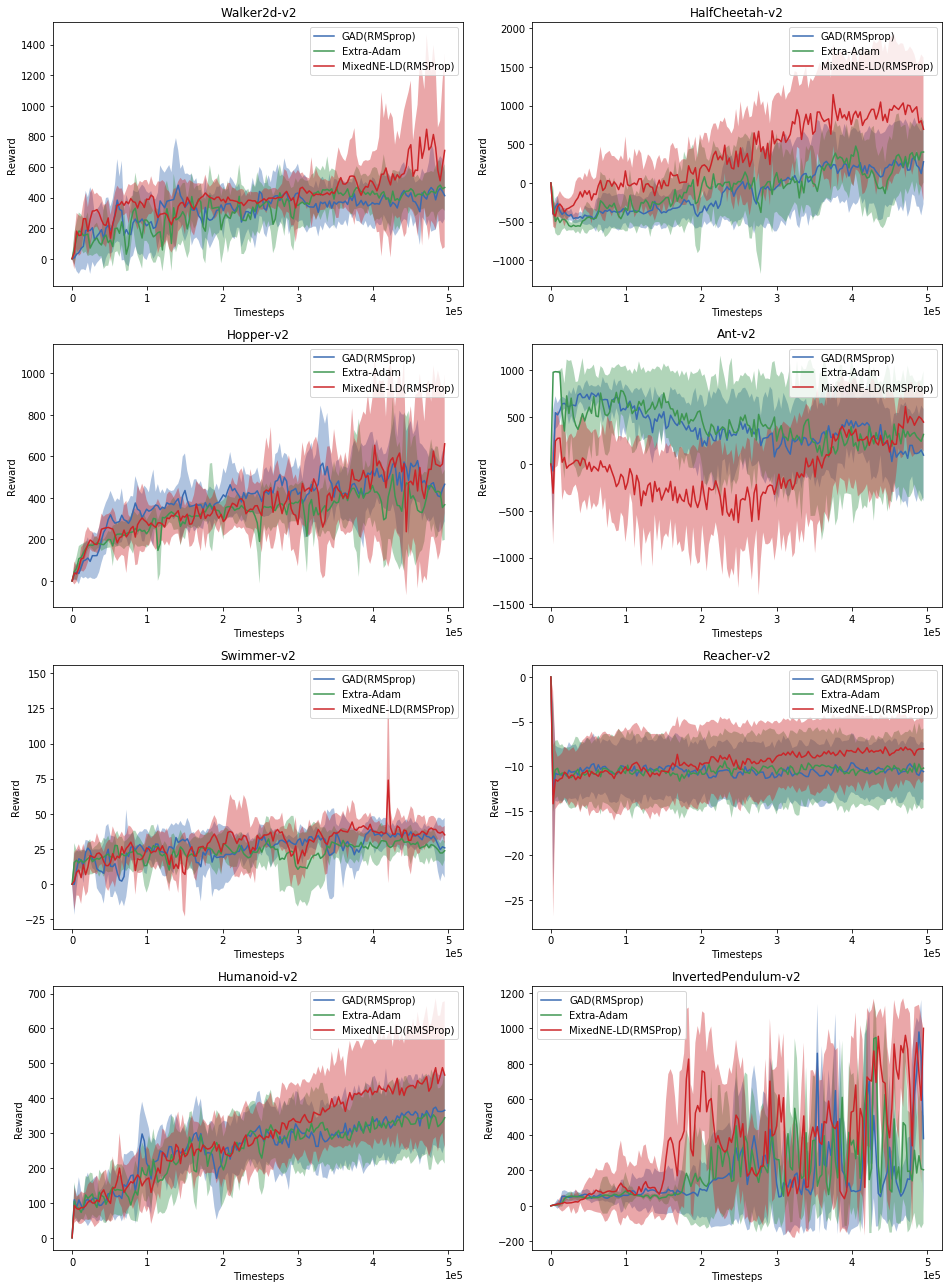

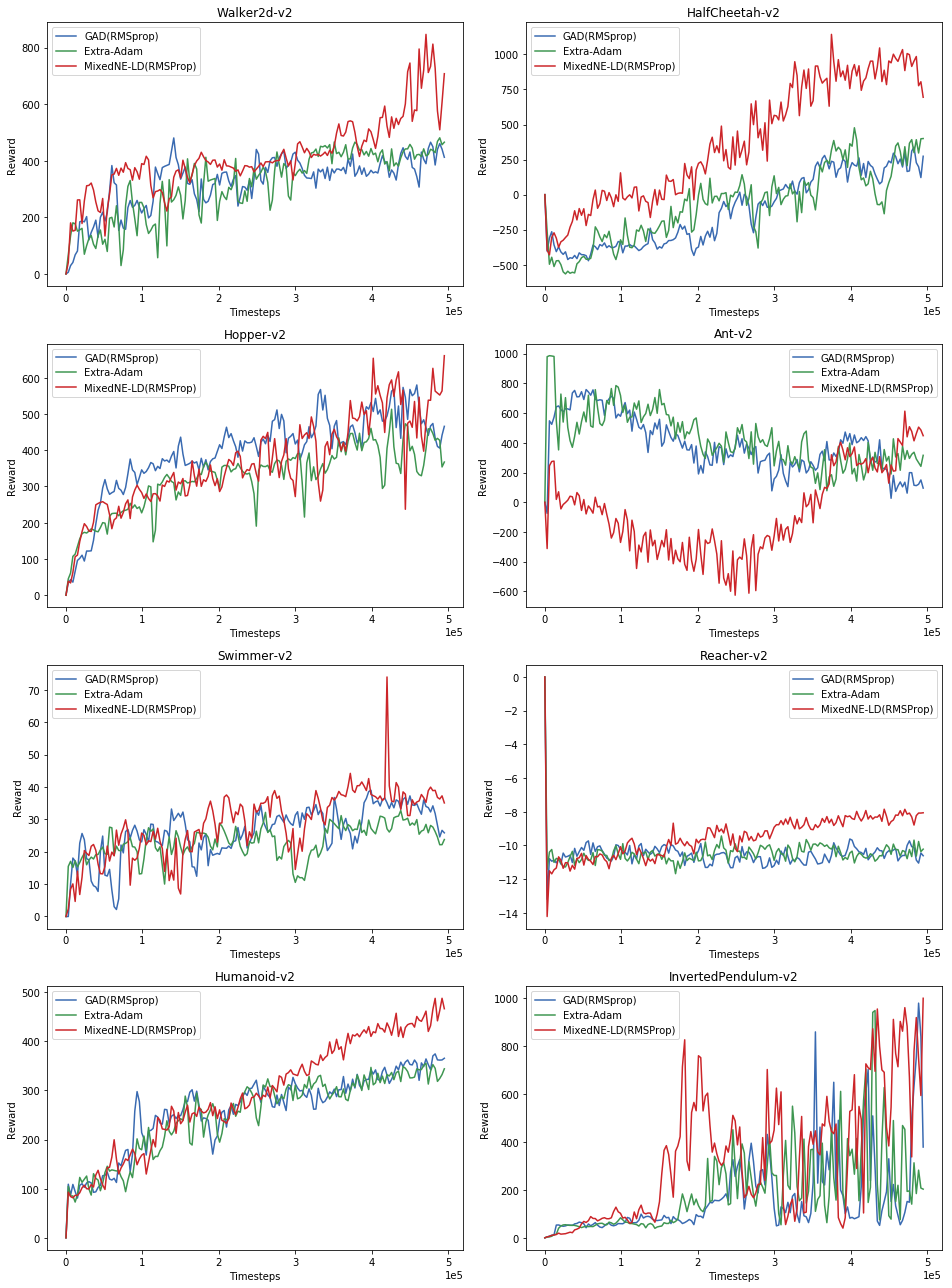

In [11]:
## Comparison Two Player Average
Walker_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.01']
InvertedPendulum_exp = ['RMSprop/action_noise_0.1', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/action_noise_0.01']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
plot_learning_all(exp, 'Comparison', comparison = True, OnePlayer = False, best = False)

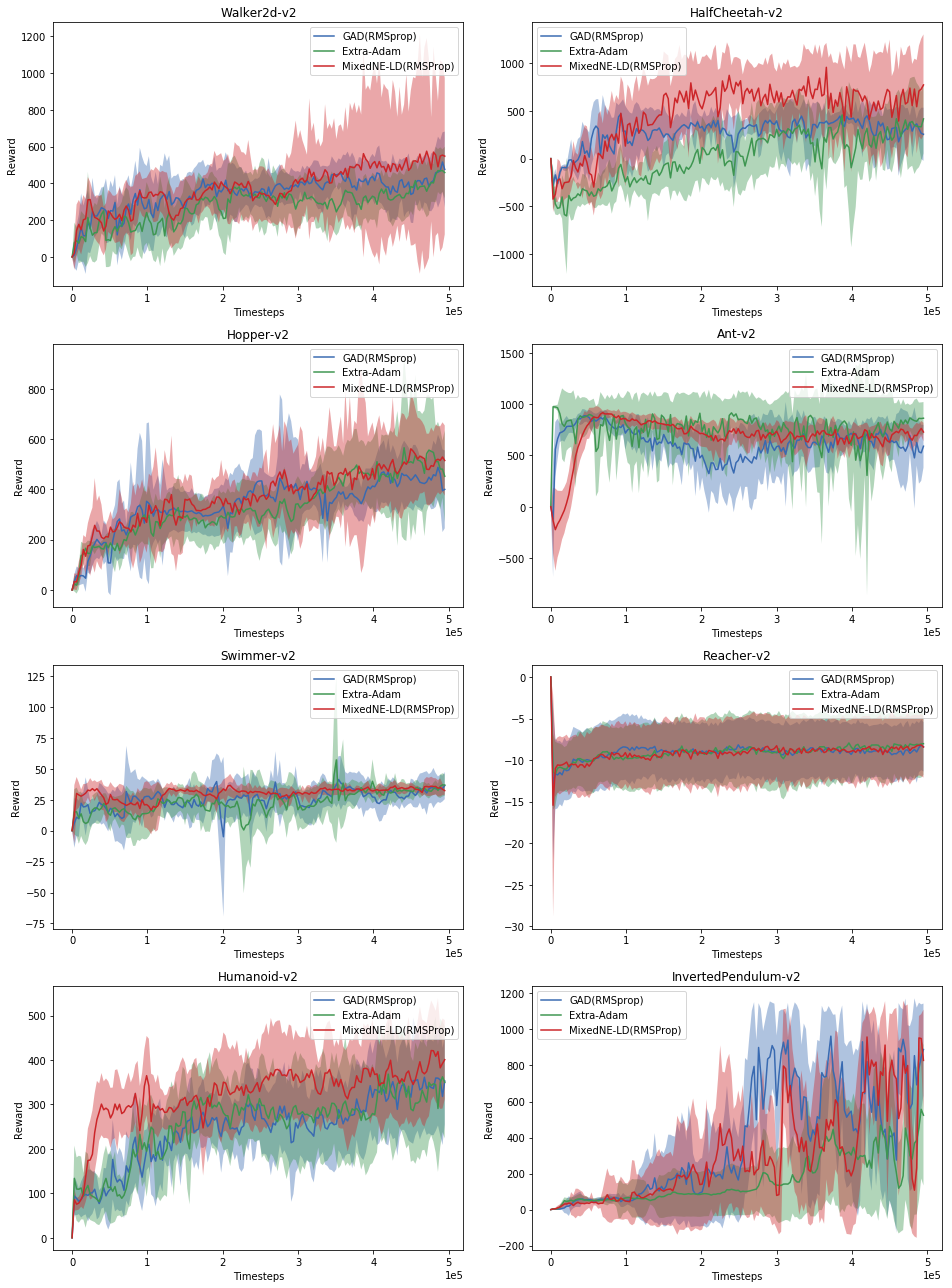

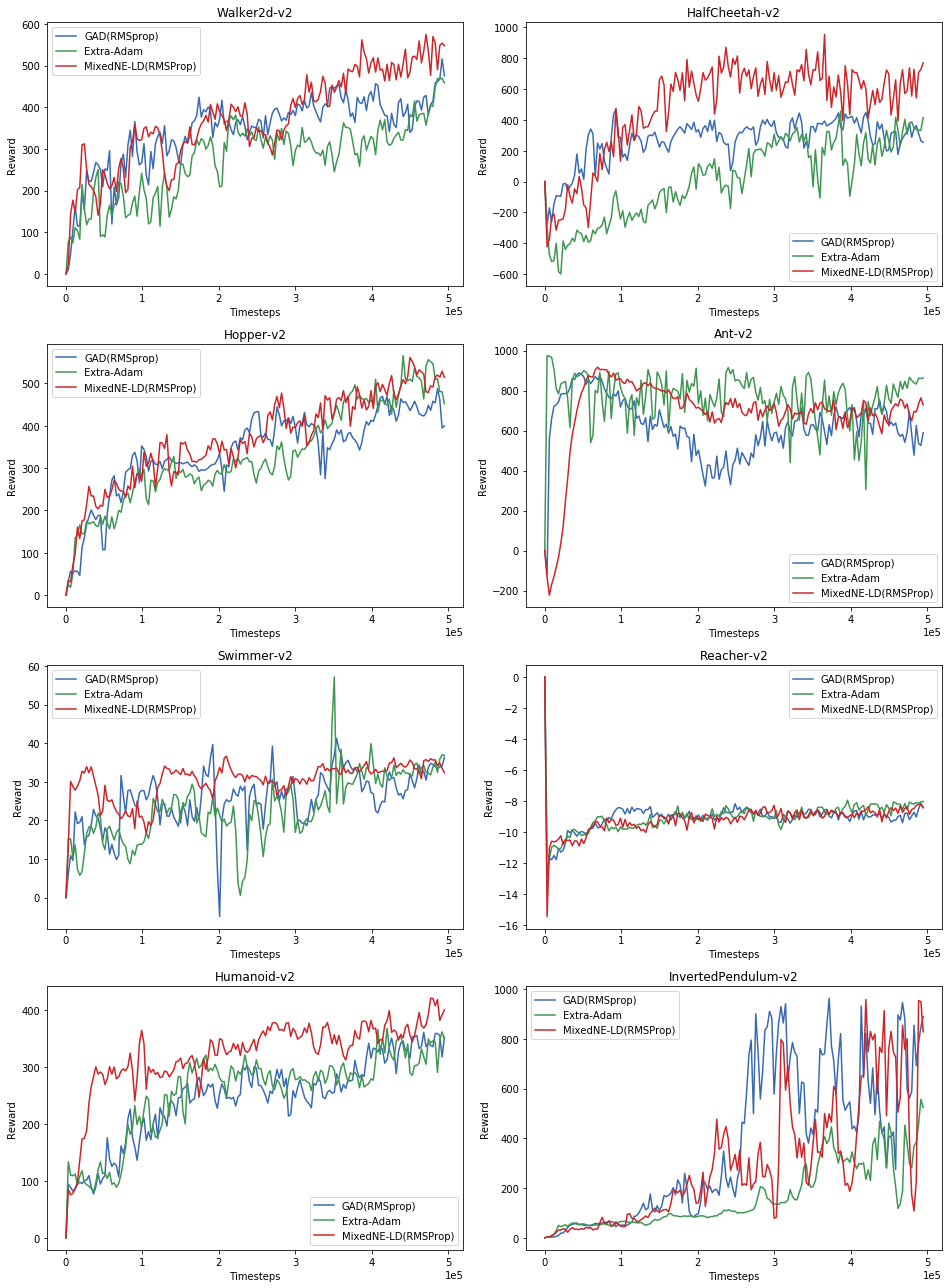

In [25]:
## Comparison One Player Average
Walker_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.1', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.01']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.2']
Reacher_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/no_noise']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp] 
plot_learning_all(exp, 'Comparison', comparison = True, OnePlayer = True, best = False)

In [3]:
## Comparison Two Player Best
Walker_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.3', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_exp = ['RMSprop/no_noise', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']
InvertedPendulum_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    

Walker_seed = [0, 4]
Hopper_seed = [3, 4]
HalfCheetah_seed = [3, 2]
Ant_seed = [1, 3]
Swimmer_seed = [4, 2]
Reacher_seed = [4, 2]
Humanoid_seed = [2, 4]
InvertedPendulum_seed = [2, 3]
seed = [Walker_seed, HalfCheetah_seed, Hopper_seed, Ant_seed, Swimmer_seed, Reacher_seed, Humanoid_seed, InvertedPendulum_seed] 

plot_learning_all(exp, 'Comparison', comparison = True, OnePlayer = False, best = True, seed = seed)

NameError: name 'plot_learning_all' is not defined

In [4]:
## Comparison One Player Best
Walker_exp = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_exp = ['RMSprop/action_noise_0.3', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.0001/action_noise_0.01']
Reacher_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/action_noise_0.1', 'SGLD_thermal_0.01/action_noise_0.3']
InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.0001/no_noise']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
 
Walker_seed = [2, 0]
Hopper_seed = [4, 2]
HalfCheetah_seed = [4, 4]
Ant_seed = [2, 1]
Swimmer_seed = [2, 2]
Reacher_seed = [2, 0]
Humanoid_seed = [2, 3]
InvertedPendulum_seed = [2, 3]
seed = [Walker_seed, HalfCheetah_seed, Hopper_seed, Ant_seed, Swimmer_seed, Reacher_seed, Humanoid_seed, InvertedPendulum_seed] 

plot_learning_all(exp, 'Comparison', comparison = True, OnePlayer = True, best = True, seed = seed)

NameError: name 'plot_learning_all' is not defined

## Mass Uncertainty Plots

In [17]:
def plot_env(env_name, params, ax, var, OnePlayer, best, seed=None):

    if OnePlayer:
        base_dir = os.getcwd() + '/models_OnePlayer/' + env_name
    else:
        base_dir = os.getcwd() + '/models/' + env_name
    results = {}
        
    for i, exp in enumerate(params):
        if(best):
            upper = seed[i] + 1
            lower = seed[i]
        else:
            upper = 5
            lower = 0
        results[exp] = {}
        for s in range(lower, upper):
            try:
                if(OnePlayer):
                    with open(base_dir + '/' + exp +'/nr_mdp_0_1/' + str(s) + '/results_model', 'rb') as f:
                        results[exp][s] = pickle.load(f)
                else:
                    with open(base_dir + '/' + exp +'/nr_mdp_0.1_1/' + str(s) + '/results_model', 'rb') as f:
                        results[exp][s] = pickle.load(f)                
            except IOError:
                pass
            
    plot_model(results, ax, env_name, var, OnePlayer)

def plot_model(results, ax, env_name, var, OnePlayer):
    x = [i for i in range(21)]
    colors = ['#396ab1','#3e9651', '#cc2529', '#da7c30', '#94823d', '#535154', '#00FF00', '#800000', '#F08080', '#FFFF00', '#000000', '#C0C0C0']
    
    idx = 0
    for exp in results:
        if exp not in ['results_model']:
            avg = []
            std = []
            for seed in results[exp]:
                avg_seed = []
                std_seed = []
                for mass in results[exp][seed]:
                    avg_seed.append(np.mean(results[exp][seed][mass]))
                    std_seed.append(np.std(results[exp][seed][mass]) / np.sqrt(len(results[exp][seed][mass]) - 1) * 2)
                avg.append(avg_seed)
                std.append(std_seed)
            avg = np.array(avg)
            std = np.array(std)
            avg = np.mean(avg, axis=0)
            std = np.mean(std, axis=0)
            
        if 'RMSprop' in exp:
            l = 'GAD (RMSprop)'
        elif 'ExtraAdam' in exp:
            l = 'Extra-Adam'
        else:
            l = 'MixedNE-LD (RMSProp)'                
        if(OnePlayer):
            ax.plot(x, avg, color=colors[idx], linestyle="--")
        else:
            l = r'$\beta=$'+ str(exp[45:48]) + r', $K_t$='+ str(exp[52:53])
            ax.plot(x, avg, label=l, color=colors[idx], linestyle="-")
        if(var):
            ax.fill_between(x, np.array(avg) - np.array(std), np.array(avg) + np.array(std), facecolor=colors[idx], alpha=0.2, interpolate=True)
        idx += 1
    ax.set_title(env_name)         
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xticklabels([0.5, 0.75, 1.0, 1.5, 2.0])
    ax.set_xlabel('Relative mass')
    ax.set_ylabel('Reward')

In [38]:
def plot_env_all(params, title, comparison, OnePlayer, best, seed = None):
    cols = 2
    rows = 4
    envs = ['Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Ant-v2', 'Swimmer-v2', 'Reacher-v2', 'Humanoid-v2', 'InvertedPendulum-v2']
    fill = [True, False]
    for f in fill:
        fig, axs = plt.subplots(rows, cols, figsize=(20*cols/3, 9*rows/2))
        for i, env in enumerate(envs):
            ax = axs.flatten()[i]
            if(comparison):
                param = params[i]
            else:
                param = params
            if(best):
                plot_env(env, param, ax, var = f, OnePlayer = OnePlayer, best = best, seed = seed[i])
            else:
                plot_env(env, param, ax, var = f, OnePlayer = OnePlayer, best = best)                
            if(comparison):
                ax.legend(loc='upper left')
            else:
                if i == 0:
                    ax.legend()
        plt.tight_layout()
        
        if(OnePlayer):
            folder = 'OnePlayer'
        else:
            folder = 'TwoPlayer'
            
        if(f):
            if(best):
                plt.savefig('plots/'+ folder + '/Mass_Uncertainty/' + title +'_best_fill.pdf')
            else:
                plt.savefig('plots/'+ folder + '/Mass_Uncertainty/' + title +'_average_fill.pdf')                    
        else:
            if(best):
                plt.savefig('plots/'+ folder + '/Mass_Uncertainty/' + title +'_best.pdf')
            else:
                plt.savefig('plots/'+ folder + '/Mass_Uncertainty/' + title +'_average.pdf')

In [39]:
def plot_env_merge(params, title, comparison):
    cols = 2
    rows = 4
    envs = ['Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2', 'Ant-v2', 'Swimmer-v2', 'Reacher-v2', 'Humanoid-v2', 'InvertedPendulum-v2']
    fill = [True, False]
    for f in fill:
        fig, axs = plt.subplots(rows, cols, figsize=(20*cols/3, 9*rows/2))
        for i, env in enumerate(envs):
            ax = axs.flatten()[i]
            if(comparison):
                param = params[i]
            else:
                param = params
            plot_env(env, param[0:3], ax, var = f, OnePlayer = True, best = False)
            plot_env(env, param[3:6], ax, var = f, OnePlayer = False, best = False)                
            if(comparison):
                ax.legend(loc='upper left')
            else:
                if i == 0:
                    ax.legend()
        plt.tight_layout()
        if(f):
            plt.savefig('plots/Merged/Mass_Uncertainty_fill.pdf')
        else:
            plt.savefig('plots/Merged/Mass_Uncertainty.pdf')

### Merged Results for OnePlayer and TwoPlayer

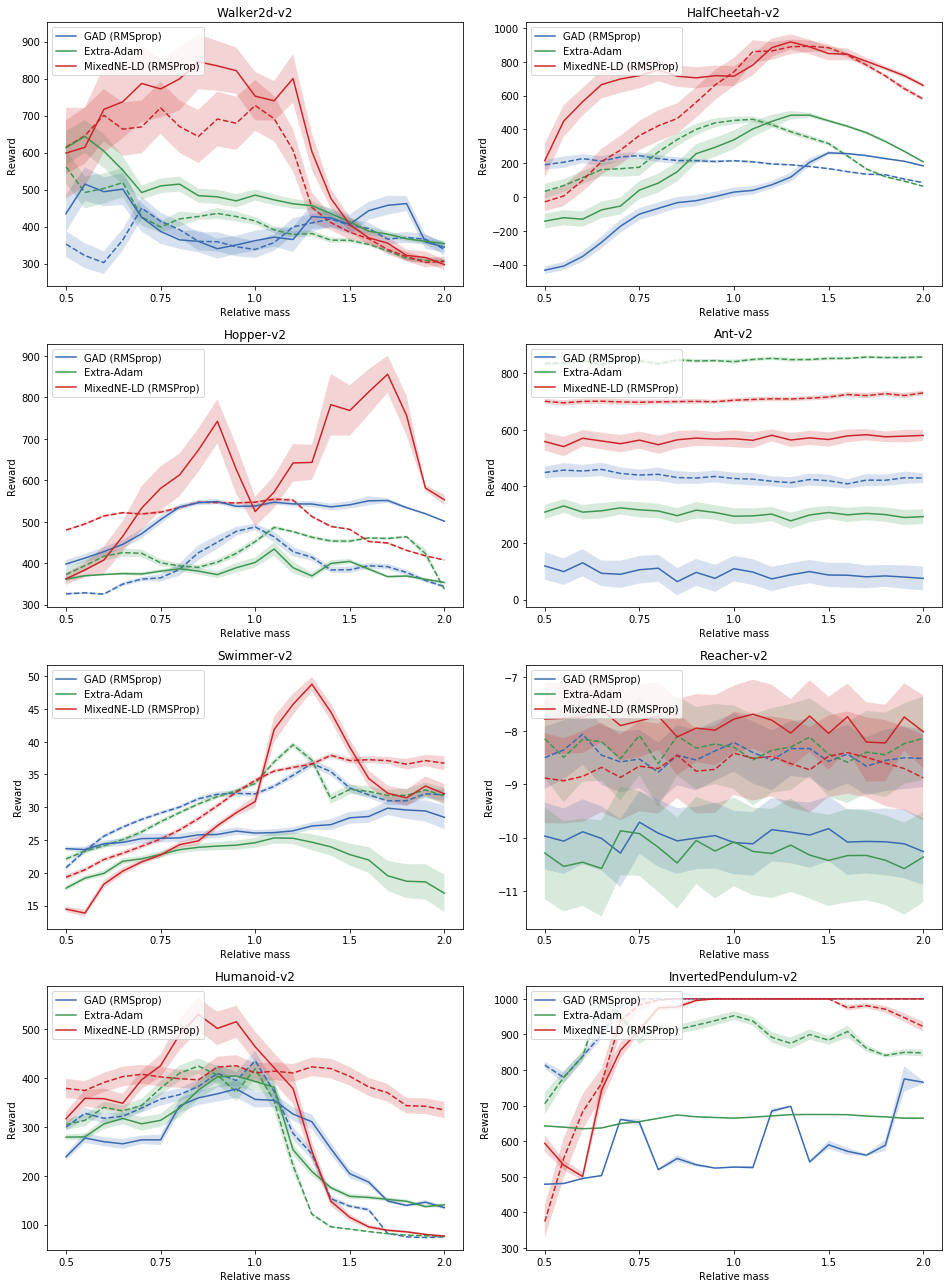

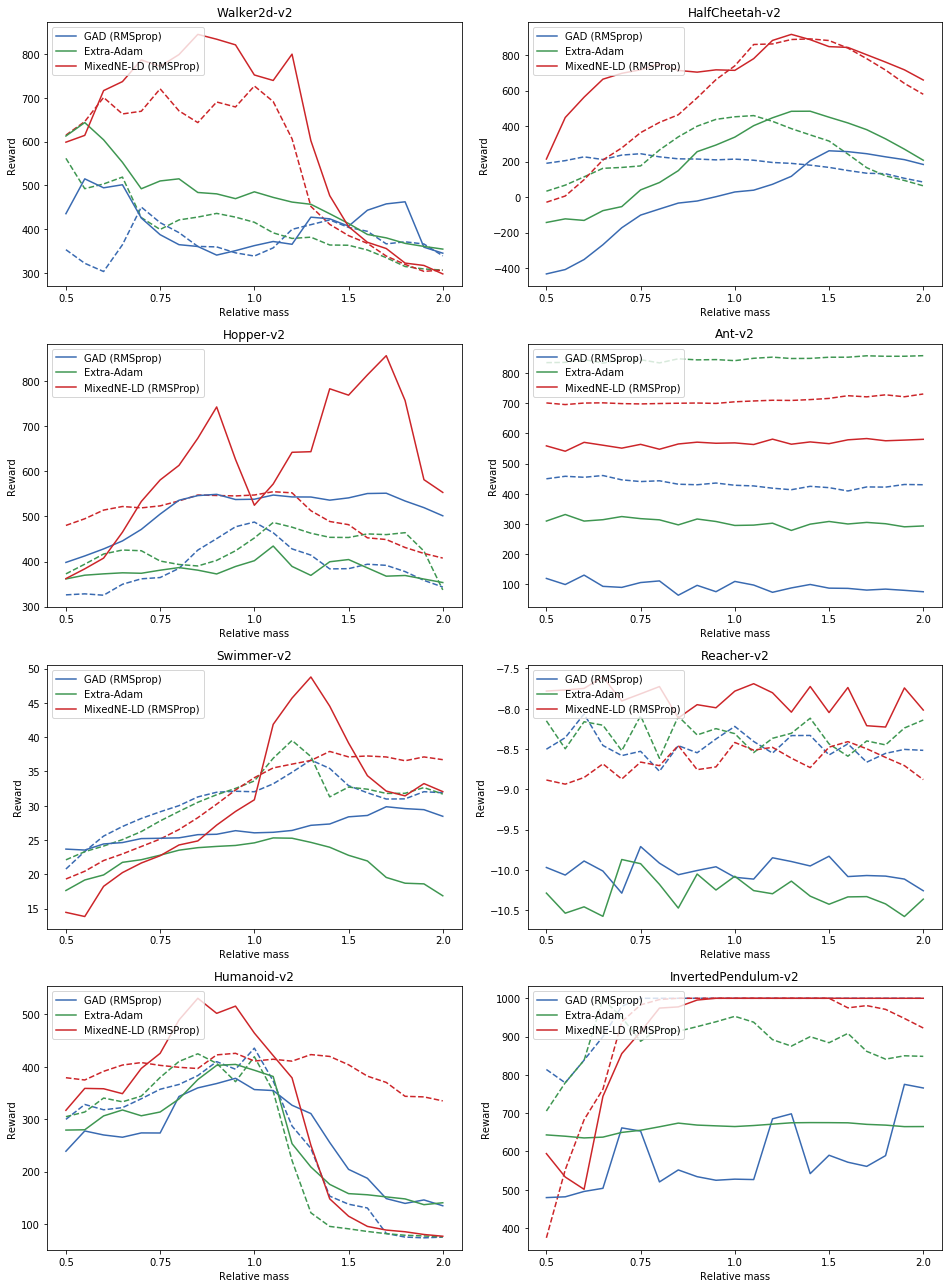

In [40]:
Walker_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.01/action_noise_0.1', #single player
             'RMSprop/no_noise','ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.01']    #two player

Hopper_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.1', 'SGLD_thermal_1e-05/action_noise_0.3',
               'RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.001/action_noise_0.2']

HalfCheetah_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.01',\
                   'RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/no_noise']

Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.4',\
        'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.2']

Swimmer_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.2',\
               'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'SGLD_thermal_1e-05/action_noise_0.4']

Reacher_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2',\
               'RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']

Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1',\
                'RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.01']

InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/no_noise',\
                        'RMSprop/action_noise_0.1', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/action_noise_0.01']
params = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
plot_env_merge(params, title = 'Comparison', comparison = True)

### Average Results for OnePlayer and TwoPlayer

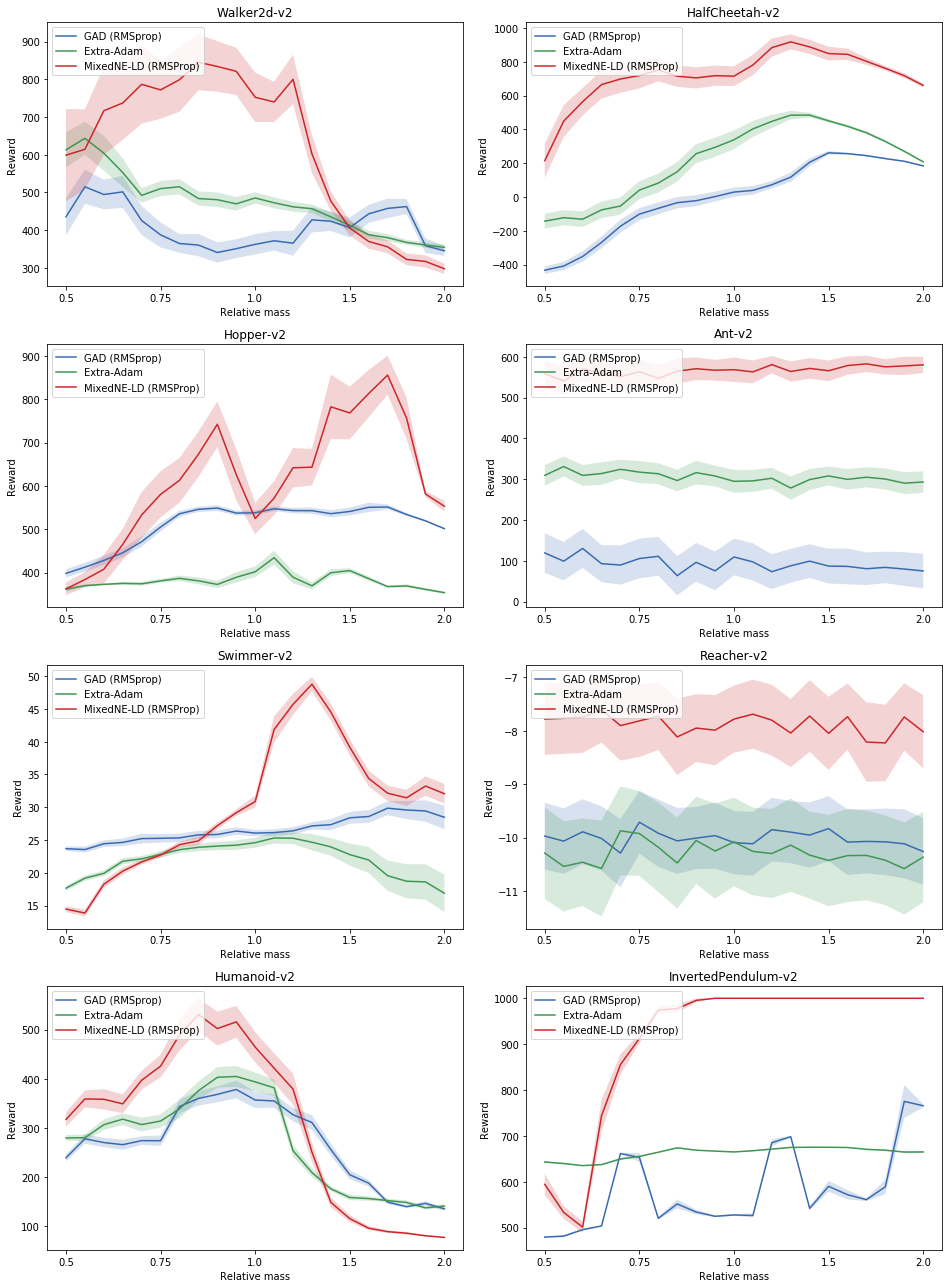

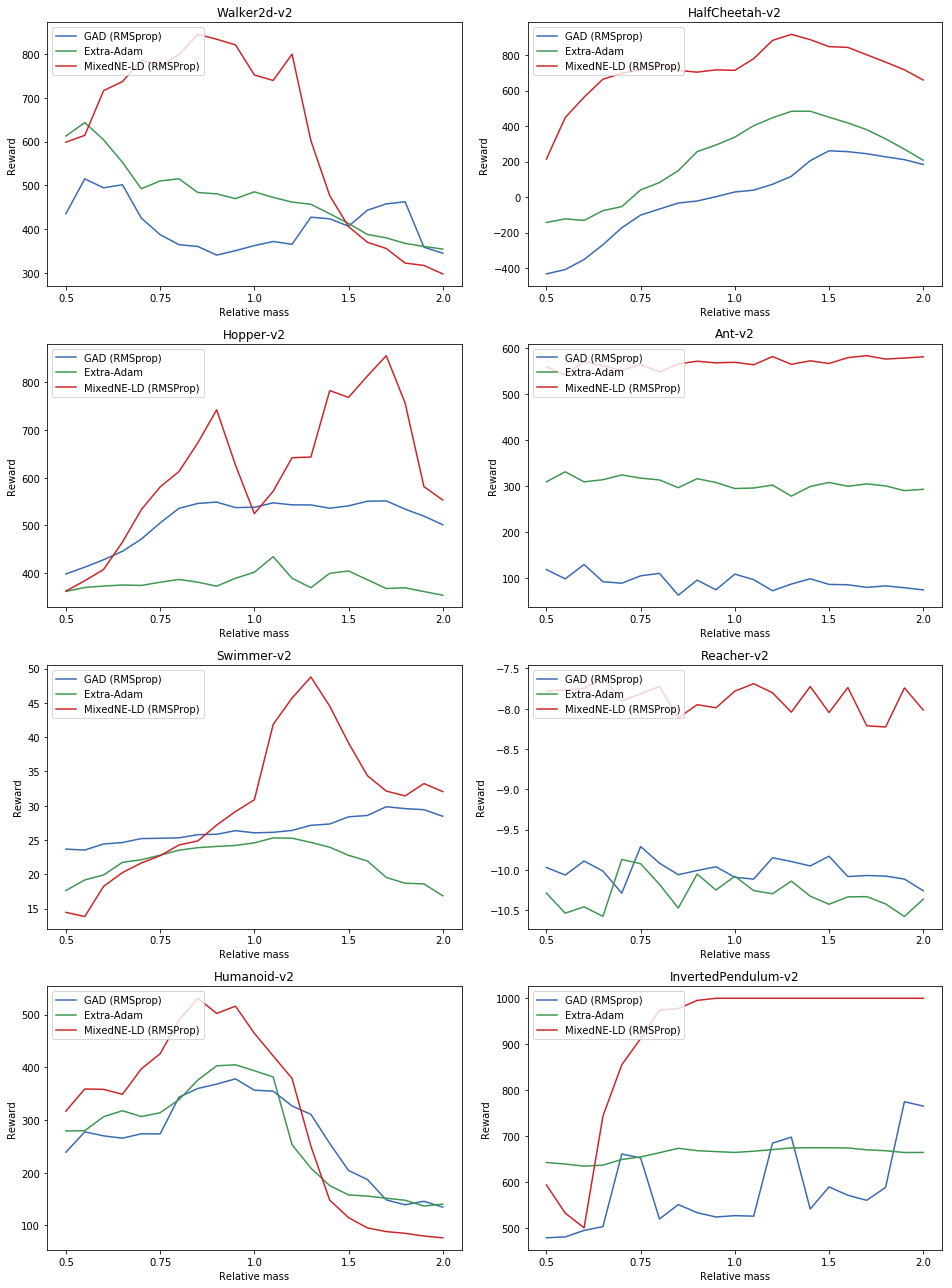

In [35]:
## Comparison Two Player Average
Walker_exp = ['RMSprop/no_noise','ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.01']
InvertedPendulum_exp = ['RMSprop/action_noise_0.1', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/action_noise_0.01']
params = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
plot_env_all(params, title = 'Comparison', comparison = True, OnePlayer = False, best = False)

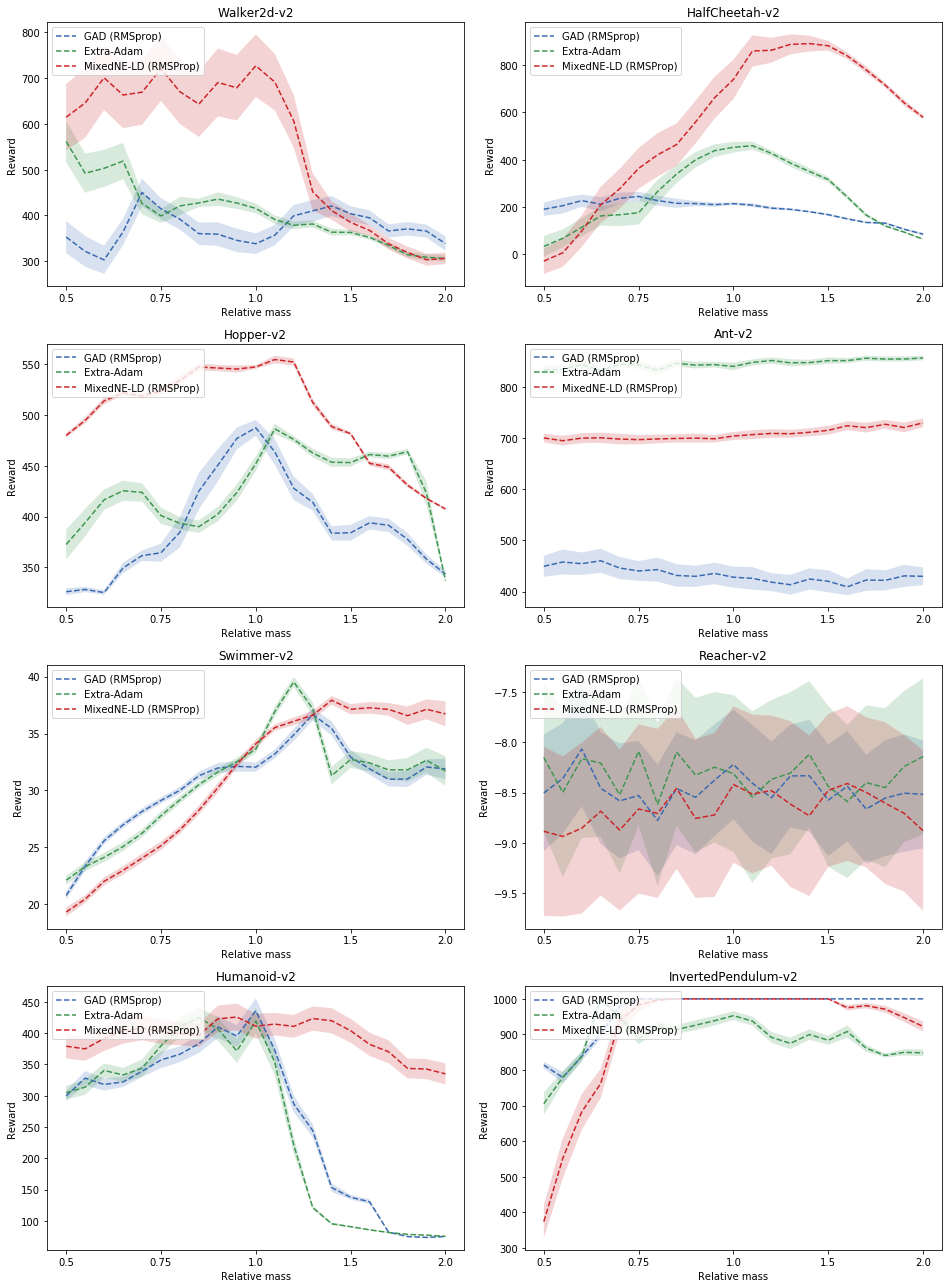

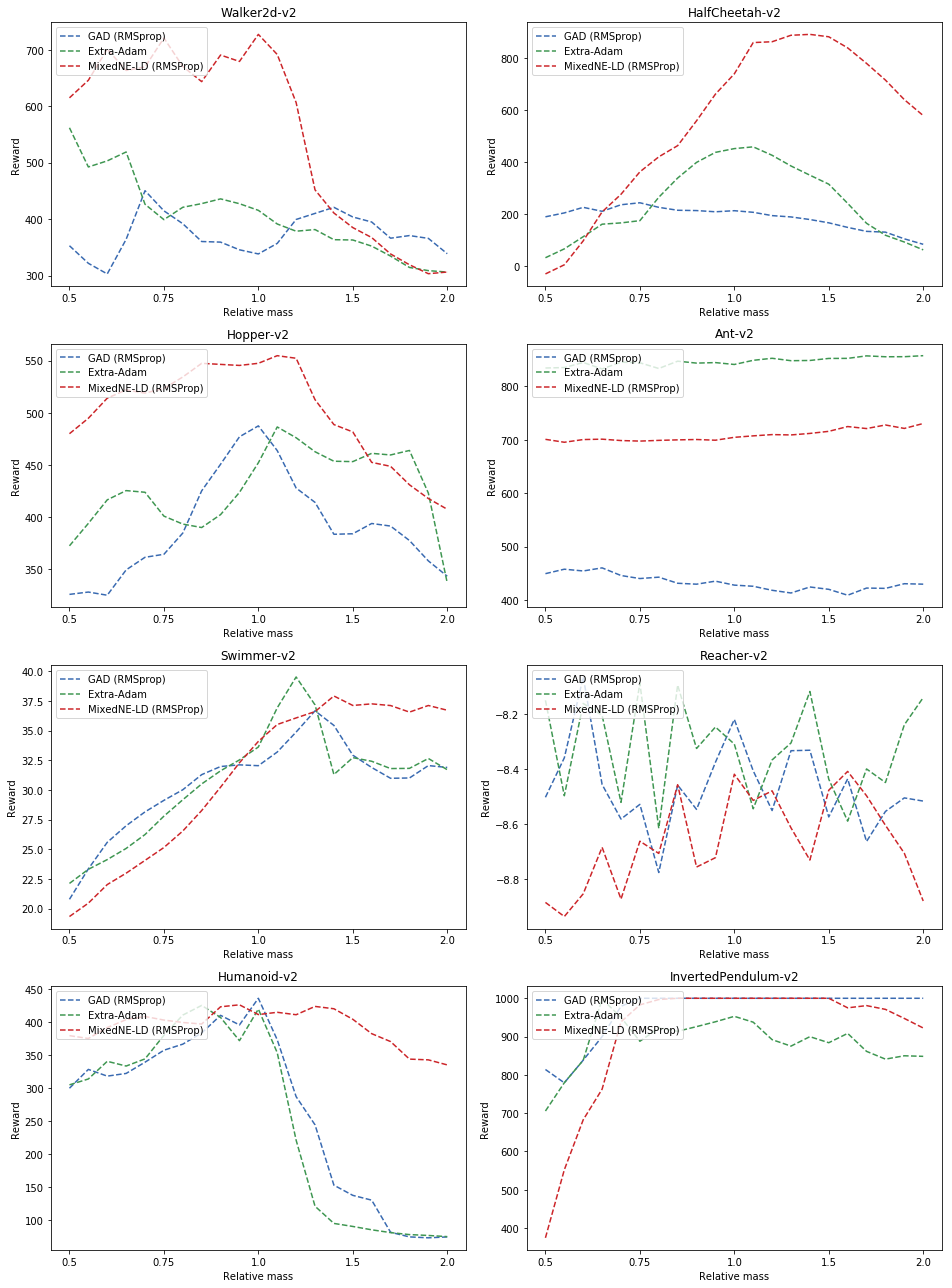

In [36]:
## Comparison One Player Average
Walker_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.1', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.01']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.2']
Reacher_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/no_noise']
params = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
plot_env_all(params, 'Comparison', comparison = True, OnePlayer = True, best = False)

### Best Seed Results for OnePlayer and TwoPlayer

In [16]:
## Comparison Two Player Best
Walker_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.3', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_exp = ['RMSprop/no_noise', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']
InvertedPendulum_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
Walker_seed = [0, 4]
Hopper_seed = [3, 4]
HalfCheetah_seed = [3, 2]
Ant_seed = [1, 3]
Swimmer_seed = [4, 2]
Reacher_seed = [4, 2]
Humanoid_seed = [2, 4]
InvertedPendulum_seed = [2, 3]

seed = [Walker_seed, HalfCheetah_seed, Hopper_seed, Ant_seed, Swimmer_seed, Reacher_seed, Humanoid_seed, InvertedPendulum_seed] 
plot_env_all(exp, 'Comparison', comparison = True, OnePlayer = False, best = True, seed = seed)

In [19]:
## Comparison One Player Best
Walker_exp = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_exp = ['RMSprop/action_noise_0.3', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_exp = ['RMSprop/no_noise', 'SGLD_thermal_0.0001/action_noise_0.01']
Reacher_exp = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/action_noise_0.1', 'SGLD_thermal_0.01/action_noise_0.3']
InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.0001/no_noise']
exp = [Walker_exp, HalfCheetah_exp, Hopper_exp, Ant_exp, Swimmer_exp, Reacher_exp, Humanoid_exp, InvertedPendulum_exp]    
 
Walker_seed = [2, 0]
Hopper_seed = [4, 2]
HalfCheetah_seed = [4, 4]
Ant_seed = [2, 1]
Swimmer_seed = [2, 2]
Reacher_seed = [2, 0]
Humanoid_seed = [2, 3]
InvertedPendulum_seed = [2, 3]
seed = [Walker_seed, HalfCheetah_seed, Hopper_seed, Ant_seed, Swimmer_seed, Reacher_seed, Humanoid_seed, InvertedPendulum_seed] 

plot_env_all(exp, 'Comparison', comparison = True, OnePlayer = True, best = True, seed = seed)

/home/yuyu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### Ablation

In [46]:
def plot_ablation(env_name, params, ax, var):

    base_dir = os.getcwd() + '/models/' + env_name
    results = {}
        
    for i, exp in enumerate(params):
        results[exp] = {}
        for s in range(5):
            try:
                with open(base_dir + '/' + exp + str(s) + '/results_model', 'rb') as f:
                    results[exp][s] = pickle.load(f)             
            except IOError:
                pass
            
    plot_model(results, ax, env_name, var, OnePlayer=False)

def plot_ablation_all(params, title, comparison):
    cols = 1
    rows = 1
    envs = ['HalfCheetah-v2']
    fill = [True, False]
    for f in fill:
        fig, axs = plt.subplots(rows, cols, figsize=(20*cols/3, 9*rows/2))
        for i, env in enumerate(envs):
            ax = axs
            if(comparison):
                param = params[i]
            else:
                param = params
            plot_ablation(env, param, ax, var = f)                
            if(comparison):
                ax.legend(loc='upper left')
            else:
                if i == 0:
                    ax.legend()
        plt.tight_layout()
        if(f):
            plt.savefig('plots/TwoPlayer/Mass_Uncertainty/Ablation_fill.pdf')
        else:
            plt.savefig('plots/TwoPlayer/Mass_Uncertainty/Ablation.pdf')

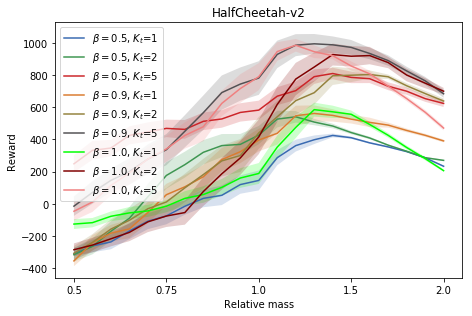

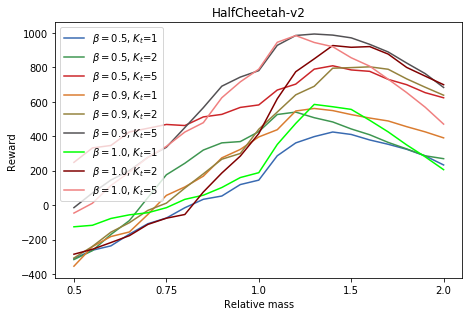

In [47]:
param = 'SGLD_thermal_0.01/no_noise/nr_mdp_0.1_1/'
_exp = [param+'beta_0.5/Kt_1/', param+'beta_0.5/Kt_2/', param+'beta_0.5/Kt_5/', param+'beta_0.9/Kt_1/', param+'beta_0.9/Kt_2/',\
              param+'beta_0.9/Kt_5/', param+'beta_1.0/Kt_1/', param+'beta_1.0/Kt_2/', param+'beta_1.0/Kt_5/']
exp = [_exp]    
plot_ablation_all(exp, title = 'Ablation', comparison = True)

## Heatmap

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_2d(env_name, params, OnePlayer, best, seed=None):
    if OnePlayer:
        base_dir = os.getcwd() + '/models_OnePlayer/' + env_name
    else:
        base_dir = os.getcwd() + '/models/' + env_name

    results = {}
    vmin = 2000
    vmax = -2000
    for idx, param in enumerate(params):
        if(best):
            upper = seed[idx] + 1
            lower = seed[idx]
        else:
            upper = 5
            lower = 0
        try:
            mat = np.zeros((11, 11))
            for s in range(lower, upper):
                if(OnePlayer):
                    with open(base_dir + '/' + param + '/nr_mdp_0_1/'+str(s)+'/results_model_noise', 'rb') as f:
                        data = pickle.load(f)
                else:
                    with open(base_dir + '/' + param + '/nr_mdp_0.1_1/'+str(s)+'/results_model_noise', 'rb') as f:
                        data = pickle.load(f)                  
                row = 0
                for key in data:
                    col = 0
                    for key2 in data[key]:
                        mat[row, col] += np.mean(data[key][key2])
                        col += 1
                    row += 1
            mat = mat/5
            results[param] = mat

            vmin = min(vmin, np.min(mat))
            vmax = max(vmax, np.max(mat))
        except:
            pass
    
    plt.figure(figsize=(7, 7))
    idx = 1
    for key in results:
        
        plt.subplot(1, 4, idx)
        idx += 1
        ax = plt.gca()
        im = ax.imshow(results[key], cmap='autumn', interpolation='nearest', vmin=vmin, vmax=vmax)
        x = [0,2,4,6,8,10]
        #[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
        labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        plt.xticks(x, labels, fontsize=4)

        y = [0,2,4,6,8,10]
        #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
        labels = [0.5, 0.7, 0.9, 1.2, 1.6, 2.0]
        plt.yticks(y, labels, fontsize=4)

        plt.xlabel('Noise Probability', fontsize=5)
        plt.ylabel('Relative Mass', fontsize=5)
        if "RMSprop" in key:
            plt.title('GAD' + '/' + env_name, fontsize=6)
        elif "ExtraAdam" in key:
            plt.title('Extra-Adam' + '/' + env_name, fontsize=6)
        else:
            plt.title('MixedNE-LD' + '/' + env_name, fontsize=6)            
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.13)

        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=4) 
    plt.tight_layout()
    
    if(OnePlayer):
        folder = 'OnePlayer'
    else:
        folder = 'TwoPlayer'
    
    if(best):
        plt.savefig('plots/'+ folder + '/Heat_map/' + env_name +'_best.pdf', bbox_inches='tight',pad_inches=0.0, dpi= 300)
    else:
        plt.savefig('plots/'+ folder + '/Heat_map/' + env_name +'_average.pdf', bbox_inches='tight',pad_inches=0.0, dpi = 300) 

### Average results

In [ ]:
## Comparison Two Player Average
Walker_exp = ['RMSprop/no_noise','ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_exp = ['RMSprop/action_noise_0.2', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/no_noise']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.4', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.0001/action_noise_0.01']
InvertedPendulum_exp = ['RMSprop/action_noise_0.1', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/action_noise_0.01']

plot_2d('Walker2d-v2', Walker_exp, OnePlayer = False, best = False)
plot_2d('Hopper-v2', Hopper_exp, OnePlayer = False, best = False)
plot_2d('HalfCheetah-v2', HalfCheetah_exp, OnePlayer = False, best = False)
plot_2d('Ant-v2', Ant_exp, OnePlayer = False, best = False)
plot_2d('Swimmer-v2', Swimmer_exp, OnePlayer = False, best = False)
plot_2d('Reacher-v2', Reacher_exp, OnePlayer = False, best = False)
plot_2d('Humanoid-v2', Humanoid_exp, OnePlayer = False, best = False)
plot_2d('InvertedPendulum-v2', InvertedPendulum_exp, OnePlayer = False, best = False)

In [ ]:
## Comparison One Player Average
Walker_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.1', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.01']
Ant_exp = ['RMSprop/action_noise_0.4', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.3', 'SGLD_thermal_0.01/action_noise_0.2']
Reacher_exp = ['RMSprop/action_noise_0.3', 'ExtraAdam/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_exp = ['RMSprop/no_noise', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
InvertedPendulum_exp = ['RMSprop/action_noise_0.01', 'ExtraAdam/action_noise_0.01', 'SGLD_thermal_0.001/no_noise']

plot_2d('Walker2d-v2', Walker_exp, OnePlayer = True, best = False)
plot_2d('Hopper-v2', Hopper_exp, OnePlayer = True, best = False)
plot_2d('HalfCheetah-v2', HalfCheetah_exp, OnePlayer = True, best = False)
plot_2d('Ant-v2', Ant_exp, OnePlayer = True, best = False)
plot_2d('Swimmer-v2', Swimmer_exp, OnePlayer = True, best = False)
plot_2d('Reacher-v2', Reacher_exp, OnePlayer = True, best = False)
plot_2d('Humanoid-v2', Humanoid_exp, OnePlayer = True, best = False)
plot_2d('InvertedPendulum-v2', InvertedPendulum_exp, OnePlayer = True, best = False)

### Best seed results

In [ ]:
## Comparison Two Player Best
Walker_param = ['RMSprop/no_noise', 'SGLD_thermal_0.01/action_noise_0.01']
Hopper_param = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.001/action_noise_0.2']
HalfCheetah_param = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_param = ['RMSprop/action_noise_0.3', 'SGLD_thermal_0.0001/action_noise_0.2']
Swimmer_param = ['RMSprop/no_noise', 'SGLD_thermal_1e-05/action_noise_0.4']
Reacher_param = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_param = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']
InvertedPendulum_param = ['RMSprop/no_noise', 'SGLD_thermal_0.001/no_noise']

Walker_seed = [0, 4]
Hopper_seed = [3, 4]
HalfCheetah_seed = [3, 2]
Ant_seed = [1, 3]
Swimmer_seed = [4, 2]
Reacher_seed = [4, 2]
Humanoid_seed = [2, 4]
InvertedPendulum_seed = [2, 3]


plot_2d('Walker2d-v2', Walker_param, OnePlayer = False, best = True, seed = Walker_seed)
plot_2d('Hopper-v2', Hopper_param, OnePlayer = False, best = True, seed = Hopper_seed)
plot_2d('HalfCheetah-v2', HalfCheetah_param, OnePlayer = False, best = True, seed = HalfCheetah_seed)
plot_2d('Ant-v2', Ant_param, OnePlayer = False, best = True, seed = Ant_seed)
plot_2d('Swimmer-v2', Swimmer_param, OnePlayer = False, best = True, seed = Swimmer_seed)
plot_2d('Reacher-v2', Reacher_param, OnePlayer = False, best = True, seed = Reacher_seed)
plot_2d('Humanoid-v2', Humanoid_param, OnePlayer = False, best = True, seed = Humanoid_seed)
plot_2d('InvertedPendulum-v2', InvertedPendulum_param, OnePlayer = False, best = True, seed = InvertedPendulum_seed)

In [ ]:
## Comparison One Player Best
Walker_param = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.01/action_noise_0.1']
Hopper_param = ['RMSprop/action_noise_0.3', 'SGLD_thermal_1e-05/action_noise_0.3']
HalfCheetah_param = ['RMSprop/action_noise_0.2', 'SGLD_thermal_0.01/no_noise']
Ant_param = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.01/action_noise_0.4']
Swimmer_param = ['RMSprop/no_noise', 'SGLD_thermal_0.0001/action_noise_0.01']
Reacher_param = ['RMSprop/action_noise_0.4', 'SGLD_thermal_0.001/action_noise_0.2']
Humanoid_param = ['RMSprop/action_noise_0.1', 'SGLD_thermal_0.01/action_noise_0.3']
InvertedPendulum_param = ['RMSprop/action_noise_0.01', 'SGLD_thermal_0.0001/no_noise']

Walker_seed = [2, 0]
Hopper_seed = [4, 2]
HalfCheetah_seed = [4, 4]
Ant_seed = [2, 1]
Swimmer_seed = [2, 2]
Reacher_seed = [2, 0]
Humanoid_seed = [2, 3]
InvertedPendulum_seed = [2, 3]

plot_2d('Walker2d-v2', Walker_param, OnePlayer = True, best = True, seed = Walker_seed)
plot_2d('Hopper-v2', Hopper_param, OnePlayer = True, best = True, seed = Hopper_seed)
plot_2d('HalfCheetah-v2', HalfCheetah_param, OnePlayer = True, best = True, seed = HalfCheetah_seed)
plot_2d('Ant-v2', Ant_param, OnePlayer = True, best = True, seed = Ant_seed)
plot_2d('Swimmer-v2', Swimmer_param, OnePlayer = True, best = True, seed = Swimmer_seed)
plot_2d('Reacher-v2', Reacher_param, OnePlayer = True, best = True, seed = Reacher_seed)
plot_2d('Humanoid-v2', Humanoid_param, OnePlayer = True, best = True, seed = Humanoid_seed)
plot_2d('InvertedPendulum-v2', InvertedPendulum_param, OnePlayer = True, best = True, seed = InvertedPendulum_seed)

### Ablation

In [58]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_2d(env_name, params):

    base_dir = os.getcwd() + '/models/' + env_name

    results = {}
    vmin = 2000
    vmax = -2000
    for idx, param in enumerate(params):
        try:
            mat = np.zeros((11, 11))
            for s in range(5):
                with open(base_dir + '/' + param +str(s)+'/results_model_noise', 'rb') as f:
                    data = pickle.load(f)                  
                row = 0
                for key in data:
                    col = 0
                    for key2 in data[key]:
                        mat[row, col] += np.mean(data[key][key2])
                        col += 1
                    row += 1
            mat = mat/5
            results[param] = mat

            vmin = min(vmin, np.min(mat))
            vmax = max(vmax, np.max(mat))
        except:
            pass
    
    plt.figure(figsize=(8, 8))
    idx = 1
    for exp in results:
        
        plt.subplot(3, 3, idx)
        idx += 1
        ax = plt.gca()
        im = ax.imshow(results[exp], cmap='autumn', interpolation='nearest', vmin=vmin, vmax=vmax)
        x = [0,2,4,6,8,10]
        #[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
        labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
        plt.xticks(x, labels, fontsize=6)

        y = [0,2,4,6,8,10]
        #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
        labels = [0.5, 0.7, 0.9, 1.2, 1.6, 2.0]
        plt.yticks(y, labels, fontsize=6)

        plt.xlabel('Noise Probability', fontsize=7)
        plt.ylabel('Relative Mass', fontsize=7)
        l = r'$\beta=$'+ str(exp[45:48]) + r', $K_t$='+ str(exp[52:53])
        plt.title(l, fontsize=10)            
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.13)

        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=6) 
    plt.tight_layout()
    plt.savefig('plots/TwoPlayer/Heat_map/Ablation.pdf')

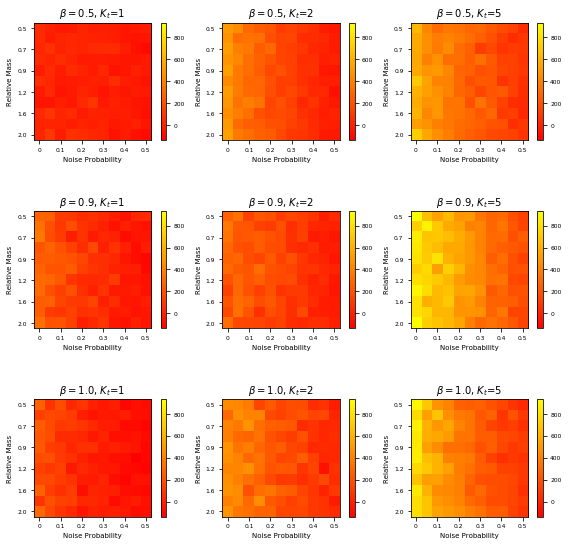

In [59]:
param = 'SGLD_thermal_0.01/no_noise/nr_mdp_0.1_1/'
exp = [param+'beta_0.5/Kt_1/', param+'beta_0.5/Kt_2/', param+'beta_0.5/Kt_5/', param+'beta_0.9/Kt_1/', param+'beta_0.9/Kt_2/',\
              param+'beta_0.9/Kt_5/', param+'beta_1.0/Kt_1/', param+'beta_1.0/Kt_2/', param+'beta_1.0/Kt_5/']
plot_2d('HalfCheetah-v2', exp)